# Analysis of the dataset
- dataset taken from https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

In [46]:
import pandas as pd
import pickle
from sklearn.neighbors import NearestNeighbors
import warnings
from recommender import Recommender
from nltk.stem import WordNetLemmatizer
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('./data/data.csv')
df_original = df.copy()
df.head(1)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"


In [3]:
# check dtypes
df.dtypes


Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

In [4]:
# drop column Poster_Link
df.drop(['Poster_Link'], axis=1, inplace=True)


In [5]:
# create one hot encoding for every possible word in the Series_Title column
lemmatizer = WordNetLemmatizer()
punctuation = ['.', ',', '!', '?', '(', ')', '"']
all_words = set()
for title in df['Series_Title']:
    words = title.split(' ')
    for word in words:
        # remove punctuation
        for p in punctuation:
            word = word.replace(p, '')
        # convert to lowercase
        word = word.lower()
        all_words.add(word)

# remove the
all_words.remove('the')
# lemmatize words
all_words = [lemmatizer.lemmatize(word) for word in all_words]

# create one hot encoding for every word
for word in all_words:
    df[word] = df['Series_Title'].str.contains(word, case=False).astype(bool)
    # sparse column
    df[word] = pd.SparseArray(df[word], dtype=bool)

# drop Series_Title column
df.drop(['Series_Title'], axis=1, inplace=True)

In [6]:
# create one hot encoding for every possible word in the Overview column
all_words = set()
for overview in df['Overview']:
    words = overview.split(' ')
    for word in words:
        # remove punctuation
        for p in punctuation:
            word = word.replace(p, '')
        # convert to lowercase
        word = word.lower()
        all_words.add(word)

common_words = ['the', 'a', 'an']
for word in common_words:
    all_words.remove(word)

# lemmatize words
all_words = [lemmatizer.lemmatize(word) for word in all_words]

# create one hot encoding for every word
for word in all_words:
    df[word] = df['Overview'].str.contains(word, case=False).astype(bool)
    # sparse column
    df[word] = pd.SparseArray(df[word], dtype=bool)

# drop Overview column
df.drop(['Overview'], axis=1, inplace=True)

In [7]:
# print all unique values in a Release_Year column
df['Released_Year'].unique()


array(['1994', '1972', '2008', '1974', '1957', '2003', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2020',
       '2019', '2014', '1998', '1997', '1995', '1991', '1977', '1962',
       '1954', '1946', '2011', '2006', '2000', '1988', '1985', '1968',
       '1960', '1942', '1936', '1931', '2018', '2017', '2016', '2012',
       '2009', '2007', '1984', '1981', '1979', '1971', '1963', '1964',
       '1950', '1940', '2013', '2005', '2004', '1992', '1987', '1986',
       '1983', '1976', '1973', '1965', '1959', '1958', '1952', '1948',
       '1944', '1941', '1927', '1921', '2015', '1996', '1989', '1978',
       '1961', '1955', '1953', '1925', '1924', '1982', '1967', '1951',
       '1949', '1939', '1937', '1934', '1928', '1926', '1920', '1970',
       '1969', '1956', '1947', '1945', '1930', '1938', '1935', '1933',
       '1932', '1922', '1943', 'PG'], dtype=object)

In [8]:
# print row where Released_Year is PG
df[df['Released_Year'] == 'PG']


,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,...,post-apocalyptic,fighting,polish,extinct,sophie,comic,tatarigami's,rican,exquisite,activities
966,PG,U,140 min,"Adventure, Drama, History",7.6,77.0,Ron Howard,Tom Hanks,Bill Paxton,Kevin Bacon,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# swap value PG with 1995
df.loc[df['Released_Year'] == 'PG', 'Released_Year'] = 1995


In [10]:
# convert Released_Year to int
df['Released_Year'] = df['Released_Year'].astype(int)


<AxesSubplot: >

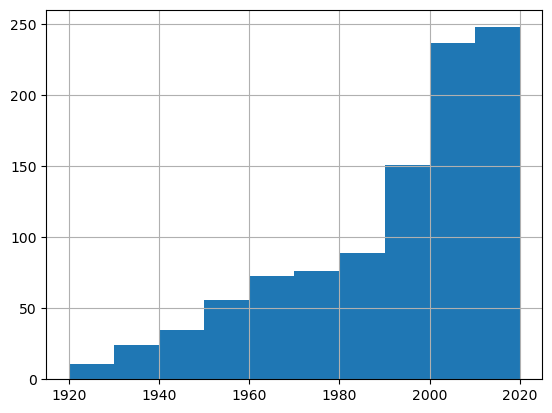

In [11]:
# plot histogram of Released_Year
df['Released_Year'].hist()


In [12]:
# print all unique values in a certificate column and their counts
df['Certificate'].value_counts()


U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: Certificate, dtype: int64

In [13]:
# all unique values with count less than 2 are replaced with 'Other'
df.loc[df['Certificate'].isin(df['Certificate'].value_counts()[df['Certificate'].value_counts() == 1].index), 'Certificate'] = 'Other'

In [14]:
# print all unique values in a certificate column and their counts
df['Certificate'].value_counts()


U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
Other         5
TV-PG         3
GP            2
Name: Certificate, dtype: int64

In [15]:
# make Certificate column categorical variable
df['Certificate'] = df['Certificate'].astype('category')


In [16]:
# one hot encode Certificate column
df = pd.get_dummies(df, columns=['Certificate'], sparse=True)


In [17]:
df.shape


(1000, 6914)

In [18]:
# top 10 genres
df['Genre'].value_counts().head(10)


Drama                           85
Drama, Romance                  37
Comedy, Drama                   35
Comedy, Drama, Romance          31
Action, Crime, Drama            30
Biography, Drama, History       28
Crime, Drama, Thriller          28
Crime, Drama, Mystery           27
Crime, Drama                    26
Animation, Adventure, Comedy    24
Name: Genre, dtype: int64

In [19]:
# convert Genre column to lowercase
df['Genre'] = df['Genre'].str.lower()


In [20]:
# looks that there are mixed genres get all genre keywords to list
genres = df['Genre'].str.split(',').values.tolist()
# flatten list
genres = [item for sublist in genres for item in sublist]
# remove whitespaces
genres = [item.strip() for item in genres]
# delete duplicates
genres = list(set(genres))
print(len(genres))
print(genres)


21
['action', 'horror', 'crime', 'history', 'musical', 'drama', 'music', 'sport', 'mystery', 'animation', 'film-noir', 'comedy', 'thriller', 'western', 'family', 'biography', 'sci-fi', 'romance', 'adventure', 'fantasy', 'war']


In [21]:
# create new columns for each genre and assign False to all rows
for genre in genres:
    df[genre] = False

# assign True to those rows where genre is present
for index, row in df.iterrows():
    for genre in row['Genre'].split(','):
        df.loc[index, genre.strip()] = True

# drop column Genre
df.drop(columns='Genre', inplace=True)


In [22]:
df.shape


(1000, 6916)

In [23]:
# one hot encode Director column
df = pd.get_dummies(df, columns=['Director'], sparse=True)


In [24]:
df.shape


(1000, 7463)

In [25]:
# print most common Stars from columns Star1, Star2, Star3, Star4 use pandas concat
all_stars = pd.concat([df['Star1'], df['Star2'], df['Star3'], df['Star4']])
all_stars.value_counts().head(20)
# convert all stars to list
all_stars = all_stars.values.tolist()


In [26]:
# create sparse column for each star
for star in all_stars:
    df[star] = False

# assign True to those rows where star is present
for index, row in df.iterrows():
    for star in [row['Star1'], row['Star2'], row['Star3'], row['Star4']]:
        df.loc[index, star] = True

# drop columns Star1, Star2, Star3, Star4
df.drop(columns=['Star1', 'Star2', 'Star3', 'Star4'], inplace=True)

# sparse columns
for star in all_stars:
    df[star] = pd.SparseArray(df[star], dtype='bool')


In [27]:
# print 5 most common runtime values
df['Runtime'].value_counts().head(5)


100 min    23
130 min    23
129 min    22
101 min    22
113 min    22
Name: Runtime, dtype: int64

In [28]:
# delete mins from runtime values
df['Runtime'] = df['Runtime'].str.replace('min', '')


In [29]:
# convert runtime values to int
df['Runtime'] = df['Runtime'].astype(int)


<AxesSubplot: ylabel='Frequency'>

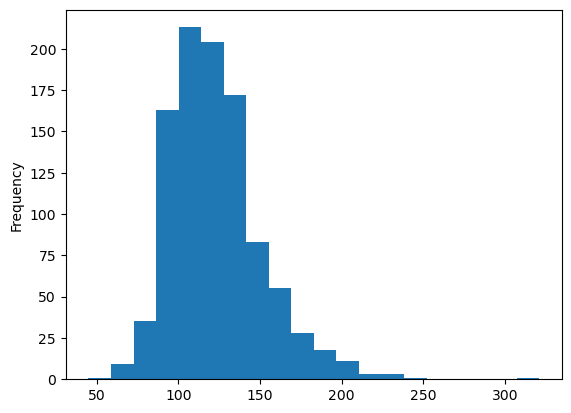

In [30]:
# plot histogram of runtime values
df['Runtime'].plot(kind='hist', bins=20)


In [31]:
# print all unique values in a Gross column and their counts
df['Gross'].value_counts()


4,360,000      5
25,000,000     2
5,450,000      2
5,321,508      2
9,600,000      2
              ..
106,662        1
10,950         1
4,018,695      1
141,319,928    1
30,500,000     1
Name: Gross, Length: 823, dtype: int64

In [32]:
# count NaN values in Gross column
df['Gross'].isna().sum()


169

In [33]:
# convert Gross values to int, replace ',' with ''
df['Gross'] = df['Gross'].str.replace(',', '')
# replace Nan values with 0
df['Gross'] = df['Gross'].fillna(0)
df['Gross'] = df['Gross'].astype(int)


<AxesSubplot: ylabel='Frequency'>

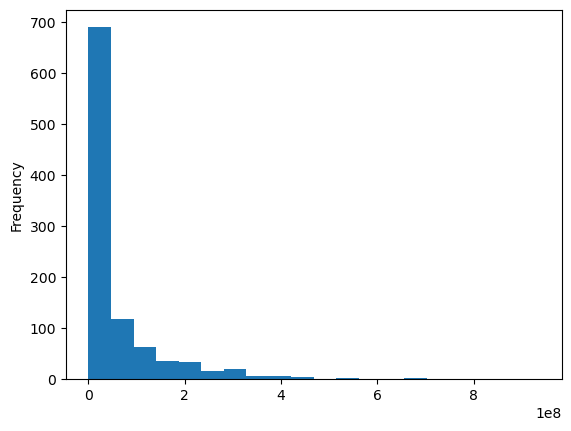

In [34]:
# plot histogram of Gross values
df['Gross'].plot(kind='hist', bins=20)


In [35]:
def one_row_differs(df, column_name):
    """
    Check if there are only 2 possible values in the column and only one row differs
    """
    values = df[column_name].value_counts()
    if len(values) == 2:
        if values.iloc[0] == 1 or values.iloc[1] == 1:
            return True
    return False
    

In [36]:
# drop columns where there is only one row different, because they don't provide any information and can't connect to any other column
total_columns_length = len(df.columns)
for i, column in enumerate(df.columns):
    if one_row_differs(df, column):
        print(f'progress: {i/total_columns_length * 100} % ', end='\r')
        df.drop(columns=[column], inplace=True)

# print how many columns were dropped
print(f'columns dropped: {total_columns_length - len(df.columns)} out of {total_columns_length}, now we have {len(df.columns)} columns')
    

## features prep done
- check

In [37]:
# print columns with nan values and their counts, only columns with nan values are printed
na_columns = df.isna().sum()[df.isna().sum() > 0]
print(na_columns)
# aplply mean imputation to all columns with nan values
df[na_columns.index] = df[na_columns.index].fillna(df[na_columns.index].mean())


Meta_score    157
dtype: int64


In [38]:
# check if number of object columns is 0
assert df.select_dtypes(include=['object']).shape[1] == 0
# check for any NaN values
assert df.isna().sum().sum() == 0


In [39]:
# apply standardization to all columns with values greater than 1
for column in df.columns:
    if df[column].max() > 1:
        df[column] = (df[column] - df[column].mean()) / df[column].std()


In [40]:
df.head(1)


,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,three,corner,east,giant,...,John Castle,Ward Bond,Gene Lockhart,Jeremy Strong,Bill McKinney,Henry Travers,Lucy Liu,Anthony Edwards,Radha Mitchell,Bruno Kirby
0,0.119344,0.680189,4.902879,0.17853,6.321288,-0.27311,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 3921 entries, Released_Year to Bruno Kirby
dtypes: Sparse[bool, False](3686), Sparse[uint8, 0](208), bool(21), float64(6)
memory usage: 340.1 KB


## Visualization

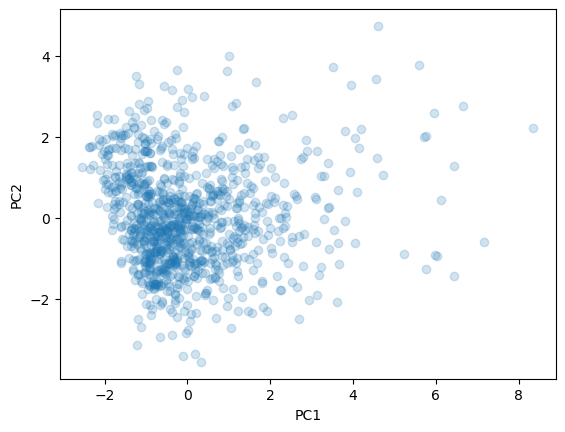

In [42]:
# visualize using PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# create PCA instance
pca = PCA(n_components=2)

# fit PCA on the data
pca.fit(df)

# transform data
df_pca = pca.transform(df)

# create a scatter plot of the transformed data
plt.scatter(df_pca[:, 0], df_pca[:, 1], alpha=0.2)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [ ]:
# save dataframe as pickle file
# df.to_pickle('./data/df_processed.pkl')